In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from nltk.tokenize import word_tokenize, regexp_tokenize
import re
import spacy
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.neural_network import MLPClassifier
from catboost import CatBoostClassifier
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
import warnings
warnings.filterwarnings('ignore')
from textatistic import Textatistic
#for pytorch
import torch
import torch.nn as nn
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#for BERT
import transformers
from transformers import AutoModel, BertTokenizerFast

In [3]:
train = pd.read_csv('train.csv')
train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [4]:
train['target'].value_counts()

target
0    4342
1    3271
Name: count, dtype: int64

In [5]:
test = pd.read_csv('test.csv')
test.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [7]:
train['keyword'].value_counts()

keyword
fatalities               45
deluge                   42
armageddon               42
sinking                  41
damage                   41
                         ..
forest%20fire            19
epicentre                12
threat                   11
inundation               10
radiation%20emergency     9
Name: count, Length: 221, dtype: int64

In [8]:
train['location'].value_counts()

location
USA                    104
New York                71
United States           50
London                  45
Canada                  29
                      ... 
MontrÌ©al, QuÌ©bec       1
Montreal                 1
ÌÏT: 6.4682,3.18287      1
Live4Heed??              1
Lincoln                  1
Name: count, Length: 3341, dtype: int64

### Set up Spacy as nlp

In [9]:
nlp = spacy.load("en_core_web_sm")
stopwords = spacy.lang.en.stop_words.STOP_WORDS

### To clean the text column

In [10]:
# Function to preprocess text
def preprocess(text):
    # Create Doc object
    doc = nlp(text, disable=['ner', 'parser'])
    # Generate lemmas
    lemmas = [token.lemma_ for token in doc]
    # Remove stopwords and non-alphabetic characters
    a_lemmas = [lemma.lower() for lemma in lemmas 
            if lemma.isalpha() and lemma not in stopwords]
    
    return ' '.join(a_lemmas)
  
# Apply preprocess to ted['transcript']
train['text_cleaned']  = train['text'].apply(preprocess)
train.head()

,id,keyword,location,text,target,text_cleaned
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,deed reason earthquake may allah forgive
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,forest fire near la ronge sask canada
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,resident ask shelter place notify officer evac...
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,people receive wildfire evacuation order calif...
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,send photo ruby alaska smoke wildfire pour school


In [11]:
train1 = train[['text_cleaned', 'target']]
train1.head()

,text_cleaned,target
0,deed reason earthquake may allah forgive,1
1,forest fire near la ronge sask canada,1
2,resident ask shelter place notify officer evac...,1
3,people receive wildfire evacuation order calif...,1
4,send photo ruby alaska smoke wildfire pour school,1


In [12]:
test['text_cleaned']  = test['text'].apply(preprocess)
test.head()

,id,keyword,location,text,text_cleaned
0,0,NaN,NaN,Just happened a terrible car crash,happen terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s...",hear earthquake different city stay safe
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are...",forest fire spot pond geese flee street i save
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires,apocalypse lighting spokane wildfire
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan,typhoon soudelor kill china taiwan


In [13]:
test1 = test[['text_cleaned']]
test1.head()

,text_cleaned
0,happen terrible car crash
1,hear earthquake different city stay safe
2,forest fire spot pond geese flee street i save
3,apocalypse lighting spokane wildfire
4,typhoon soudelor kill china taiwan


#### train1 and test1

In [14]:
X = train1['text_cleaned']
y = train1['target']

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify = y, random_state=0)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(5709,)
(1904,)
(5709,)
(1904,)


In [16]:
test2 = test1.squeeze()
type(test2)

pandas.core.series.Series

In [17]:
vec1 = CountVectorizer(strip_accents='ascii', stop_words='english', lowercase=True)
bow_train = vec1.fit_transform(X_train)
bow_test = vec1.transform(X_test)
test3 = vec1.transform(test2)

### Using CatBoostClassifier

In [23]:
CatBoostClassifier?

In [43]:
cat = CatBoostClassifier(learning_rate=1.0, depth=8,)
cat.fit(bow_train, y_train)

0:	learn: 0.6533064	total: 70.2ms	remaining: 1m 10s
1:	learn: 0.6221751	total: 145ms	remaining: 1m 12s
2:	learn: 0.6017785	total: 219ms	remaining: 1m 12s
3:	learn: 0.5846095	total: 298ms	remaining: 1m 14s
4:	learn: 0.5719770	total: 378ms	remaining: 1m 15s
5:	learn: 0.5625962	total: 452ms	remaining: 1m 14s
6:	learn: 0.5496374	total: 534ms	remaining: 1m 15s
7:	learn: 0.5422169	total: 613ms	remaining: 1m 16s
8:	learn: 0.5330668	total: 686ms	remaining: 1m 15s
9:	learn: 0.5190100	total: 766ms	remaining: 1m 15s
10:	learn: 0.5048430	total: 849ms	remaining: 1m 16s
11:	learn: 0.4923367	total: 921ms	remaining: 1m 15s
12:	learn: 0.4827647	total: 999ms	remaining: 1m 15s
13:	learn: 0.4744268	total: 1.08s	remaining: 1m 16s
14:	learn: 0.4652554	total: 1.15s	remaining: 1m 15s
15:	learn: 0.4585209	total: 1.23s	remaining: 1m 15s
16:	learn: 0.4519104	total: 1.31s	remaining: 1m 15s
17:	learn: 0.4458827	total: 1.38s	remaining: 1m 15s
18:	learn: 0.4364912	total: 1.46s	remaining: 1m 15s
19:	learn: 0.4305348	

161:	learn: 0.1692646	total: 12.7s	remaining: 1m 5s
162:	learn: 0.1680122	total: 12.8s	remaining: 1m 5s
163:	learn: 0.1668040	total: 12.8s	remaining: 1m 5s
164:	learn: 0.1663534	total: 12.9s	remaining: 1m 5s
165:	learn: 0.1659092	total: 13s	remaining: 1m 5s
166:	learn: 0.1652410	total: 13s	remaining: 1m 5s
167:	learn: 0.1642399	total: 13.1s	remaining: 1m 4s
168:	learn: 0.1638168	total: 13.2s	remaining: 1m 4s
169:	learn: 0.1633226	total: 13.3s	remaining: 1m 4s
170:	learn: 0.1627999	total: 13.3s	remaining: 1m 4s
171:	learn: 0.1617905	total: 13.4s	remaining: 1m 4s
172:	learn: 0.1613847	total: 13.5s	remaining: 1m 4s
173:	learn: 0.1609951	total: 13.6s	remaining: 1m 4s
174:	learn: 0.1605919	total: 13.6s	remaining: 1m 4s
175:	learn: 0.1599058	total: 13.7s	remaining: 1m 4s
176:	learn: 0.1586715	total: 13.8s	remaining: 1m 4s
177:	learn: 0.1578726	total: 13.8s	remaining: 1m 3s
178:	learn: 0.1571467	total: 13.9s	remaining: 1m 3s
179:	learn: 0.1564680	total: 14s	remaining: 1m 3s
180:	learn: 0.1559

323:	learn: 0.0981717	total: 26.1s	remaining: 54.4s
324:	learn: 0.0980291	total: 26.1s	remaining: 54.3s
325:	learn: 0.0978521	total: 26.2s	remaining: 54.2s
326:	learn: 0.0976994	total: 26.3s	remaining: 54.2s
327:	learn: 0.0970801	total: 26.4s	remaining: 54.1s
328:	learn: 0.0969425	total: 26.5s	remaining: 54s
329:	learn: 0.0967510	total: 26.6s	remaining: 53.9s
330:	learn: 0.0962683	total: 26.6s	remaining: 53.8s
331:	learn: 0.0961250	total: 26.7s	remaining: 53.8s
332:	learn: 0.0959951	total: 26.8s	remaining: 53.7s
333:	learn: 0.0957826	total: 26.9s	remaining: 53.6s
334:	learn: 0.0953524	total: 27s	remaining: 53.5s
335:	learn: 0.0952041	total: 27.1s	remaining: 53.5s
336:	learn: 0.0950754	total: 27.1s	remaining: 53.4s
337:	learn: 0.0949441	total: 27.2s	remaining: 53.3s
338:	learn: 0.0945203	total: 27.3s	remaining: 53.2s
339:	learn: 0.0943389	total: 27.4s	remaining: 53.2s
340:	learn: 0.0940889	total: 27.5s	remaining: 53.1s
341:	learn: 0.0939565	total: 27.6s	remaining: 53s
342:	learn: 0.0938

484:	learn: 0.0715847	total: 41s	remaining: 43.6s
485:	learn: 0.0715274	total: 41.1s	remaining: 43.5s
486:	learn: 0.0714711	total: 41.2s	remaining: 43.4s
487:	learn: 0.0713672	total: 41.3s	remaining: 43.3s
488:	learn: 0.0713083	total: 41.4s	remaining: 43.2s
489:	learn: 0.0712412	total: 41.4s	remaining: 43.1s
490:	learn: 0.0710300	total: 41.5s	remaining: 43s
491:	learn: 0.0709657	total: 41.6s	remaining: 43s
492:	learn: 0.0709117	total: 41.7s	remaining: 42.9s
493:	learn: 0.0708578	total: 41.8s	remaining: 42.8s
494:	learn: 0.0707589	total: 41.9s	remaining: 42.7s
495:	learn: 0.0707062	total: 41.9s	remaining: 42.6s
496:	learn: 0.0706544	total: 42s	remaining: 42.5s
497:	learn: 0.0704928	total: 42.1s	remaining: 42.4s
498:	learn: 0.0704426	total: 42.2s	remaining: 42.4s
499:	learn: 0.0703688	total: 42.3s	remaining: 42.3s
500:	learn: 0.0701551	total: 42.4s	remaining: 42.2s
501:	learn: 0.0700215	total: 42.5s	remaining: 42.1s
502:	learn: 0.0699700	total: 42.6s	remaining: 42.1s
503:	learn: 0.069921

644:	learn: 0.0586014	total: 58.8s	remaining: 32.4s
645:	learn: 0.0585665	total: 58.9s	remaining: 32.3s
646:	learn: 0.0585348	total: 59.1s	remaining: 32.3s
647:	learn: 0.0585037	total: 59.3s	remaining: 32.2s
648:	learn: 0.0584716	total: 59.5s	remaining: 32.2s
649:	learn: 0.0584416	total: 59.6s	remaining: 32.1s
650:	learn: 0.0582965	total: 59.8s	remaining: 32s
651:	learn: 0.0581630	total: 59.9s	remaining: 32s
652:	learn: 0.0581190	total: 1m	remaining: 31.9s
653:	learn: 0.0580882	total: 1m	remaining: 31.9s
654:	learn: 0.0580048	total: 1m	remaining: 31.8s
655:	learn: 0.0578908	total: 1m	remaining: 31.8s
656:	learn: 0.0578561	total: 1m	remaining: 31.7s
657:	learn: 0.0578249	total: 1m	remaining: 31.6s
658:	learn: 0.0577963	total: 1m	remaining: 31.5s
659:	learn: 0.0577490	total: 1m 1s	remaining: 31.5s
660:	learn: 0.0577022	total: 1m 1s	remaining: 31.4s
661:	learn: 0.0576740	total: 1m 1s	remaining: 31.3s
662:	learn: 0.0575425	total: 1m 1s	remaining: 31.2s
663:	learn: 0.0575110	total: 1m 1s	re

802:	learn: 0.0509178	total: 1m 14s	remaining: 18.4s
803:	learn: 0.0508912	total: 1m 14s	remaining: 18.3s
804:	learn: 0.0507965	total: 1m 15s	remaining: 18.2s
805:	learn: 0.0507684	total: 1m 15s	remaining: 18.1s
806:	learn: 0.0507366	total: 1m 15s	remaining: 18s
807:	learn: 0.0507202	total: 1m 15s	remaining: 17.9s
808:	learn: 0.0507010	total: 1m 15s	remaining: 17.8s
809:	learn: 0.0506835	total: 1m 15s	remaining: 17.7s
810:	learn: 0.0506481	total: 1m 15s	remaining: 17.6s
811:	learn: 0.0505488	total: 1m 15s	remaining: 17.5s
812:	learn: 0.0505154	total: 1m 15s	remaining: 17.5s
813:	learn: 0.0504860	total: 1m 15s	remaining: 17.4s
814:	learn: 0.0504676	total: 1m 16s	remaining: 17.3s
815:	learn: 0.0503608	total: 1m 16s	remaining: 17.2s
816:	learn: 0.0503354	total: 1m 16s	remaining: 17.1s
817:	learn: 0.0503198	total: 1m 16s	remaining: 17s
818:	learn: 0.0503016	total: 1m 16s	remaining: 16.9s
819:	learn: 0.0502452	total: 1m 16s	remaining: 16.8s
820:	learn: 0.0502216	total: 1m 16s	remaining: 16.

960:	learn: 0.0462805	total: 1m 34s	remaining: 3.84s
961:	learn: 0.0462701	total: 1m 34s	remaining: 3.74s
962:	learn: 0.0462393	total: 1m 34s	remaining: 3.65s
963:	learn: 0.0462125	total: 1m 34s	remaining: 3.55s
964:	learn: 0.0461787	total: 1m 35s	remaining: 3.45s
965:	learn: 0.0461691	total: 1m 35s	remaining: 3.35s
966:	learn: 0.0461074	total: 1m 35s	remaining: 3.25s
967:	learn: 0.0460909	total: 1m 35s	remaining: 3.15s
968:	learn: 0.0460779	total: 1m 35s	remaining: 3.05s
969:	learn: 0.0460576	total: 1m 35s	remaining: 2.95s
970:	learn: 0.0460159	total: 1m 35s	remaining: 2.85s
971:	learn: 0.0459829	total: 1m 35s	remaining: 2.76s
972:	learn: 0.0459712	total: 1m 35s	remaining: 2.66s
973:	learn: 0.0459544	total: 1m 36s	remaining: 2.56s
974:	learn: 0.0459356	total: 1m 36s	remaining: 2.47s
975:	learn: 0.0458977	total: 1m 36s	remaining: 2.37s
976:	learn: 0.0458864	total: 1m 36s	remaining: 2.27s
977:	learn: 0.0458635	total: 1m 36s	remaining: 2.17s
978:	learn: 0.0458389	total: 1m 36s	remaining:

In [44]:
pred_cat = cat.predict(bow_test)
metrics.accuracy_score(y_test, pred_cat)

0.7988445378151261

In [45]:
print(metrics.classification_report(y_test, pred_cat))

              precision    recall  f1-score   support

           0       0.79      0.87      0.83      1086
           1       0.81      0.70      0.75       818

    accuracy                           0.80      1904
   macro avg       0.80      0.79      0.79      1904
weighted avg       0.80      0.80      0.80      1904



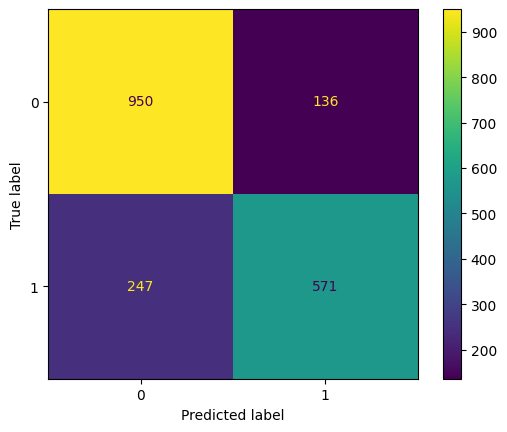

In [46]:
cm_cat = metrics.confusion_matrix(y_test, pred_cat)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix=cm_cat, display_labels=[0,1])
cm_display.plot()
plt.show()

In [47]:
pred_catt = cat.predict(test3)
df_id = pd.DataFrame({'id':test['id']})
df_cat = pd.DataFrame(pred_catt,columns=['target'])  
df_cat = pd.concat([df_id, df_cat],axis=1)
df_cat.head()

,id,target
0,0,1
1,2,1
2,3,1
3,9,1
4,11,1


In [48]:
df_cat.to_csv('target_cat.csv', index=False)

### GridSearchCV

In [49]:
CBC = CatBoostClassifier()
parameters = {'depth'         : [4,5,6,7,8,9, 10],
                 'learning_rate' : [0.01,0.02,0.03,0.04],
                  'iterations'    : [10, 20,30,40,50,60,70,80,90, 100]
                 }

In [50]:
Grid_CBC = GridSearchCV(estimator=CBC, param_grid = parameters, cv = 5, n_jobs=-1)
Grid_CBC.fit(bow_train, y_train)

0:	learn: 0.6890901	total: 303ms	remaining: 30s
1:	learn: 0.6845743	total: 670ms	remaining: 32.8s
2:	learn: 0.6804492	total: 1.02s	remaining: 33s
3:	learn: 0.6772591	total: 1.4s	remaining: 33.5s
4:	learn: 0.6734989	total: 1.78s	remaining: 33.8s
5:	learn: 0.6696278	total: 2.15s	remaining: 33.6s
6:	learn: 0.6665206	total: 2.5s	remaining: 33.2s
7:	learn: 0.6635450	total: 2.87s	remaining: 33s
8:	learn: 0.6608548	total: 3.17s	remaining: 32.1s
9:	learn: 0.6585653	total: 3.47s	remaining: 31.2s
10:	learn: 0.6562045	total: 3.76s	remaining: 30.5s
11:	learn: 0.6529684	total: 4.08s	remaining: 29.9s
12:	learn: 0.6511196	total: 4.13s	remaining: 27.6s
13:	learn: 0.6498541	total: 4.46s	remaining: 27.4s
14:	learn: 0.6481506	total: 4.79s	remaining: 27.1s
15:	learn: 0.6464598	total: 5.11s	remaining: 26.8s
16:	learn: 0.6449931	total: 5.44s	remaining: 26.6s
17:	learn: 0.6431179	total: 5.87s	remaining: 26.7s
18:	learn: 0.6408748	total: 6.21s	remaining: 26.5s
19:	learn: 0.6389600	total: 6.54s	remaining: 26.1

GridSearchCV(cv=5,
             estimator=<catboost.core.CatBoostClassifier object at 0x000001CAD5607790>,
             n_jobs=-1,
             param_grid={'depth': [4, 5, 6, 7, 8, 9, 10],
                         'iterations': [10, 20, 30, 40, 50, 60, 70, 80, 90,
                                        100],
                         'learning_rate': [0.01, 0.02, 0.03, 0.04]})

In [51]:
print(" Results from Grid Search " )
print("\n The best estimator across ALL searched params:\n",Grid_CBC.best_estimator_)
print("\n The best score across ALL searched params:\n",Grid_CBC.best_score_)
print("\n The best parameters across ALL searched params:\n",Grid_CBC.best_params_)

 Results from Grid Search 

 The best estimator across ALL searched params:

 The best score across ALL searched params:
 0.7199138617767007

 The best parameters across ALL searched params:
 {'depth': 10, 'iterations': 100, 'learning_rate': 0.04}


### Using MLPClassifier

In [17]:
mlp = MLPClassifier()
mlp.fit(bow_train, y_train)

MLPClassifier()

In [18]:
prd = mlp.predict(bow_test)
metrics.accuracy_score(y_test, prd)

0.7536764705882353

In [19]:
parameters = {'hidden_layer_sizes': [50, 100, 200],
             'alpha': [0.001, 0.01, 0.1],
             'max_iter': [200, 500, 800],
             'learning_rate_init': [0.0001, 0.001, 0.01, 0.1]}

In [20]:
clf = RandomizedSearchCV(estimator=mlp, param_distributions=parameters, cv=5, scoring='accuracy')
clf.fit(bow_train, y_train)

RandomizedSearchCV(cv=5, estimator=MLPClassifier(),
                   param_distributions={'alpha': [0.001, 0.01, 0.1],
                                        'hidden_layer_sizes': [50, 100, 200],
                                        'learning_rate_init': [0.0001, 0.001,
                                                               0.01, 0.1],
                                        'max_iter': [200, 500, 800]},
                   scoring='accuracy')

In [23]:
print('The best parameters values found are: \n')
print(clf.best_params_)

The best parameters values found are: 

{'max_iter': 200, 'learning_rate_init': 0.0001, 'hidden_layer_sizes': 200, 'alpha': 0.1}


In [24]:
best = clf.best_estimator_
prd = best.predict(test3)
df_id = pd.DataFrame({'id':test['id']})
df_mlp = pd.DataFrame(prd,columns=['target'])  
df_mlp = pd.concat([df_id, df_mlp],axis=1)
df_mlp.head()

,id,target
0,0,0
1,2,1
2,3,1
3,9,1
4,11,1


In [25]:
df_mlp.to_csv('target_mlp.csv', index=False)

### Using MultinomialNB

In [17]:
model = MultinomialNB(alpha=0.6)
model.fit(bow_train, y_train)

MultinomialNB(alpha=0.6)

In [18]:
yhat = model.predict(bow_test)
metrics.accuracy_score(y_test, yhat)

0.8125

In [19]:
print(metrics.classification_report(y_test, yhat))

              precision    recall  f1-score   support

           0       0.81      0.87      0.84      1086
           1       0.81      0.73      0.77       818

    accuracy                           0.81      1904
   macro avg       0.81      0.80      0.81      1904
weighted avg       0.81      0.81      0.81      1904



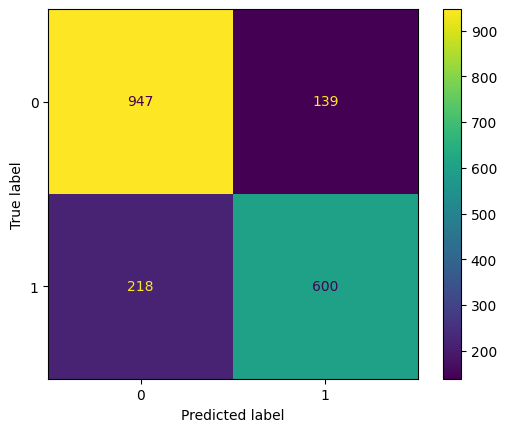

In [20]:
cm_cv = metrics.confusion_matrix(y_test, yhat)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix=cm_cv, display_labels=[0,1])
cm_display.plot()
plt.show()

In [24]:
pred = model.predict(test3)
df_id = pd.DataFrame({'id':test['id']})
df_mn = pd.DataFrame(pred,columns=['target'])  
df_mn = pd.concat([df_id, df_mn],axis=1)
df_mn.head()

,id,target
0,0,1
1,2,1
2,3,1
3,9,1
4,11,1


In [25]:
df_mn.to_csv('target.csv', index=False)

### Use SGDClassifier

In [22]:
sgd = SGDClassifier()
sgd.fit(bow_train, y_train)

SGDClassifier()

In [24]:
yhat_sgd = sgd.predict(bow_test)
metrics.accuracy_score(y_test, yhat_sgd)

0.7720588235294118

### Logistic Regression

In [42]:
logreg = LogisticRegression(C=1.0)
logreg.fit(bow_train, y_train)

LogisticRegression()

In [43]:
yhat_lr = logreg.predict(bow_test)
metrics.accuracy_score(y_test, yhat_lr)

0.8040966386554622

In [27]:
print(metrics.classification_report(y_test, yhat_lr))

              precision    recall  f1-score   support

           0       0.79      0.89      0.84      1086
           1       0.83      0.69      0.75       818

    accuracy                           0.80      1904
   macro avg       0.81      0.79      0.79      1904
weighted avg       0.81      0.80      0.80      1904



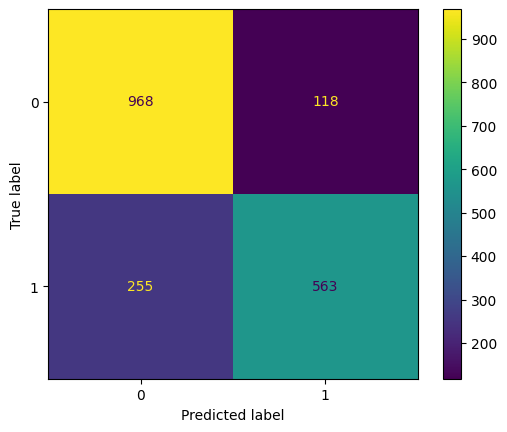

In [28]:
cm_cv = metrics.confusion_matrix(y_test, yhat_lr)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix=cm_cv, display_labels=[0,1])
cm_display.plot()
plt.show()

### Lets use transformer

In [16]:
df = train.copy()
df2 = test.copy()

In [17]:
df.head()

,id,keyword,location,text,target,text_cleaned
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,deed reason earthquake may allah forgive
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,forest fire near la ronge sask canada
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,resident ask shelter place notify officer evac...
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,people receive wildfire evacuation order calif...
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,send photo ruby alaska smoke wildfire pour school


### Using Pretrained

In [31]:
model = None

In [19]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import numpy as np
import os

In [20]:
# embedding = "https://tfhub.dev/google/nnlm-en-dim50/2"
# embedding = "https://tfhub.dev/google/nnlm-en-dim128-with-normalization/2"

In [32]:
embedding = "https://tfhub.dev/google/nnlm-en-dim128-with-normalization/2"
hub_layer = hub.KerasLayer(embedding, input_shape=[], 
                           dtype=tf.string, trainable=True)

model = Sequential()
model.add(hub_layer)
#model.add(Dense(8, activation='relu'))
model.add(Dense(1,activation='sigmoid'))

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_2 (KerasLayer)  (None, 128)               124642688 
                                                                 
 dense_4 (Dense)             (None, 1)                 129       
                                                                 
Total params: 124,642,817
Trainable params: 124,642,817
Non-trainable params: 0
_________________________________________________________________


In [33]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])
              
history = model.fit(X_train,
                    y_train,
                    epochs=5,
                    validation_data=(X_test,y_test),
                    verbose=1)

Epoch 1/5
179/179 [==============================] - 248s 1s/step - loss: 0.5757 - accuracy: 0.7362 - val_loss: 0.4806 - val_accuracy: 0.8093
Epoch 2/5
179/179 [==============================] - 306s 2s/step - loss: 0.3818 - accuracy: 0.8544 - val_loss: 0.4428 - val_accuracy: 0.8072
Epoch 3/5
179/179 [==============================] - 261s 1s/step - loss: 0.2732 - accuracy: 0.8991 - val_loss: 0.4630 - val_accuracy: 0.8046
Epoch 4/5
179/179 [==============================] - 316s 2s/step - loss: 0.2014 - accuracy: 0.9287 - val_loss: 0.5091 - val_accuracy: 0.7920
Epoch 5/5
179/179 [==============================] - 488s 3s/step - loss: 0.1528 - accuracy: 0.9497 - val_loss: 0.5541 - val_accuracy: 0.7794


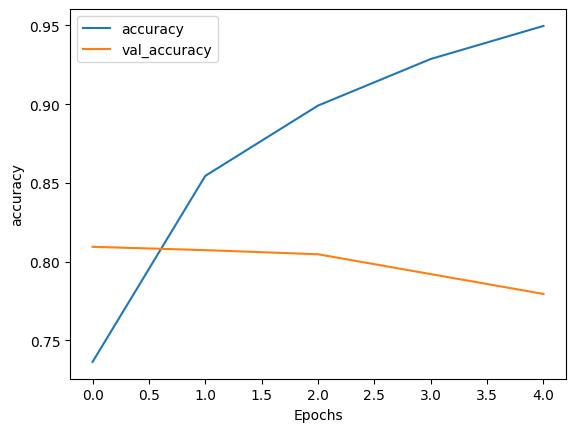

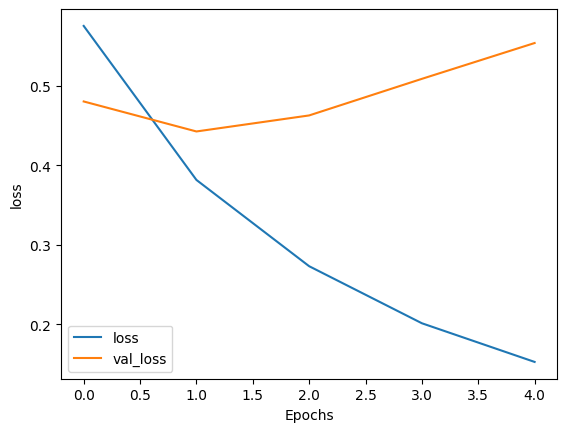

In [34]:
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [27]:
classes = model.predict(test1)

102/102 [==============================] - 15s 144ms/step


In [28]:
yhat_class = [1 if x>=0.5 else 0 for x in classes]
print(yhat_class[:5])

[1, 1, 1, 1, 1]


In [29]:
df_id = pd.DataFrame({'id':test['id']})
df_tl = pd.DataFrame(yhat_class,columns=['target'])  
df_tl = pd.concat([df_id, df_tl],axis=1)
df_tl.head()

,id,target
0,0,1
1,2,1
2,3,1
3,9,1
4,11,1


In [30]:
df_tl.to_csv('target_tf3.csv', index=False)

### RoBERTa for nlp classification

In [103]:
import torch
from transformers import RobertaTokenizer, RobertaForSequenceClassification

In [104]:
# Load the RoBERTa tokenizer and model
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
model = RobertaForSequenceClassification.from_pretrained('roberta-base')

Downloading:   0%|          | 0.00/899k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.layer_norm.bias', 'roberta.pooler.dense.bias', 'lm_head.dense.bias', 'lm_head.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'roberta.pooler.dense.weight', 'lm_head.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.weight', 'classifie

In [105]:
train_rev = train['text_cleaned'].tolist()
test_rev = test['text_cleaned'].tolist()
labels = train['target'].tolist()

In [106]:
# Tokenize the text data
inputs = tokenizer(train_rev, padding=True, truncation=True, max_length=128, return_tensors='pt')

# Convert the label data to tensor format
labels = torch.tensor(labels)

In [107]:
# Train the model
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)
for epoch in range(3):
    model.train()
    outputs = model(inputs['input_ids'], attention_mask=inputs['attention_mask'], labels=labels)
    loss = outputs.loss
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

RuntimeError: [enforce fail at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\c10\core\impl\alloc_cpu.cpp:72] data. DefaultCPUAllocator: not enough memory: you tried to allocate 771775488 bytes.

In [108]:
# Evaluate the model on a test set
test_inputs = tokenizer(test_rev, padding=True, truncation=True, max_length=128, return_tensors='pt')
# test_labels = torch.tensor(test_data['label'].tolist())

In [109]:
model.eval()
with torch.no_grad():
    outputs = model(test_inputs['input_ids'], attention_mask=test_inputs['attention_mask'], labels=test_labels)
    predictions = torch.argmax(outputs.logits, dim=-1)

NameError: name 'test_labels' is not defined

### USING TPOTClassifier

In [25]:
from tpot import TPOTClassifier

In [26]:
XT = bow_train.toarray()
X2 = bow_test.toarray()
test_main = test3.toarray()

In [31]:
tpot_clf = TPOTClassifier(generations=30, population_size=50,
                          offspring_size=100, scoring='accuracy',
                          verbosity=2, random_state=2, cv=2)
tpot_clf.fit(XT, y_train)

Optimization Progress:   0%|          | 0/3050 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: 0.7817463307712038


TPOT closed during evaluation in one generation.


TPOT closed prematurely. Will use the current best pipeline.

Best pipeline: BernoulliNB(input_matrix, alpha=1.0, fit_prior=True)


TPOTClassifier(cv=2, generations=30, offspring_size=100, population_size=50,
               random_state=2, scoring='accuracy', verbosity=2)

In [32]:
pred_tpot = tpot_clf.predict(X2)
precision, recall, f_beta, support = metrics.precision_recall_fscore_support(y_test, pred_tpot, beta=5, pos_label=1, average='macro')
auc = metrics.roc_auc_score(y_test, pred_tpot)
accuracy = metrics.accuracy_score(y_test, pred_tpot)
print(f"Accuracy is: {accuracy:.2f}")
print(f"Precision is: {precision:.2f}")
print(f"Recall is: {recall:.2f}")
print(f"Fscore is: {f_beta:.2f}")
print(f"AUC is: {auc:.2f}")

Accuracy is: 0.81
Precision is: 0.83
Recall is: 0.79
Fscore is: 0.79
AUC is: 0.79


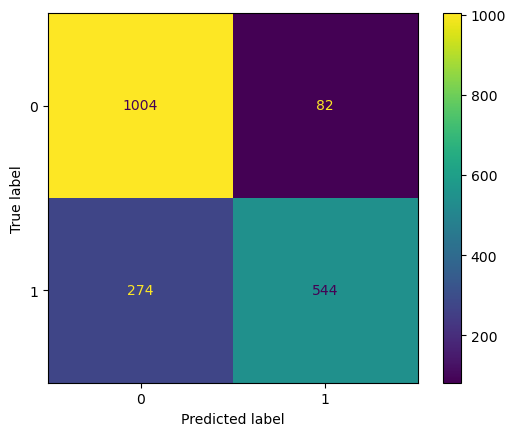

In [33]:
cm_tp = metrics.confusion_matrix(y_test, pred_tpot)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix=cm_tp, display_labels=[0,1])
cm_display.plot()
plt.show()

In [34]:
pred_tp = model.predict(test_main)
df_id = pd.DataFrame({'id':test['id']})
df_tp = pd.DataFrame(pred_tp,columns=['target'])  
df_tp = pd.concat([df_id, df_tp],axis=1)
df_tp.head()

,id,target
0,0,1
1,2,1
2,3,1
3,9,1
4,11,1


In [35]:
df_tp.to_csv('target_tpot.csv', index=False) #to be submitted 6th may

### Gridsearch on KNN

In [21]:
from sklearn.neighbors import KNeighborsClassifier

In [ ]:
params = {'n_neighbors':[3,5,7,9,11],
          'weights':['uniform', 'distance'],
          'p':[1,2,3]}

knn2 = KNeighborsClassifier()
grid_search = GridSearchCV(knn2, params, cv=5, scoring='accuracy')
grid_search.fit(XT, y_train)

C:\Users\USER\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\USER\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims`

In [ ]:
print("Best parameters found: ", grid_search.best_params_)
print("Best score: ", grid_search.best_score_)

In [ ]:
yhat_knn = grid_search.best_score_.predict(X2)
precision, recall, f_beta, support = metrics.precision_recall_fscore_support(y_test, yhat_knn, beta=5, pos_label=1, average='macro')
auc = metrics.roc_auc_score(y_test, yhat_knn)
accuracy = metrics.accuracy_score(y_test, yhat_knn)
print(f"Accuracy is: {accuracy:.2f}")
print(f"Precision is: {precision:.2f}")
print(f"Recall is: {recall:.2f}")
print(f"Fscore is: {f_beta:.2f}")
print(f"AUC is: {auc:.2f}")

In [ ]:
pred_knn = grid_search.best_score_.predict(test_main)
df_id = pd.DataFrame({'id':test['id']})
df_knn = pd.DataFrame(pred_knn,columns=['target'])  
df_knn = pd.concat([df_id, df_knn],axis=1)
df_knn.head()

### Gridsearch on RandomForest

In [ ]:
param_grid = {
    'max_features': [1, 2, 3, 4, 5],
    'min_samples_leaf': [4, 5, 6,7],
    'min_samples_split': [2,8, 10],
    'n_estimators': [50, 100, 200]}

In [ ]:
rf = RandomForestClassifier()
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 5)
grid_search.fit(XT, y_train)

In [ ]:
print("Best parameters found: ", grid_search.best_params_)
print("Best score: ", grid_search.best_score_)

In [ ]:
yhat_rf = grid_search.best_score_.predict(X2)
precision, recall, f_beta, support = metrics.precision_recall_fscore_support(y_test, yhat_rf, beta=5, pos_label=1, average='macro')
auc = metrics.roc_auc_score(y_test, yhat_rf)
accuracy = metrics.accuracy_score(y_test, yhat_rf)
print(f"Accuracy is: {accuracy:.2f}")
print(f"Precision is: {precision:.2f}")
print(f"Recall is: {recall:.2f}")
print(f"Fscore is: {f_beta:.2f}")
print(f"AUC is: {auc:.2f}")

### Using XGBCLASSIFIER

In [26]:
from xgboost import XGBClassifier

In [36]:
xgb = XGBClassifier()
xgb.fit(XT, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [37]:
yhat_xgb = xgb.predict(X2)
precision, recall, f_beta, support = metrics.precision_recall_fscore_support(y_test, yhat_xgb, beta=5, pos_label=1, average='macro')
auc = metrics.roc_auc_score(y_test, yhat_xgb)
accuracy = metrics.accuracy_score(y_test, yhat_xgb)
print(f"Accuracy is: {accuracy:.2f}")
print(f"Precision is: {precision:.2f}")
print(f"Recall is: {recall:.2f}")
print(f"Fscore is: {f_beta:.2f}")
print(f"AUC is: {auc:.2f}")

Accuracy is: 0.79
Precision is: 0.81
Recall is: 0.76
Fscore is: 0.76
AUC is: 0.76


In [38]:
pred_xgb = xgb.predict(test_main)
df_id = pd.DataFrame({'id':test['id']})
df_xgb = pd.DataFrame(pred_xgb,columns=['target'])  
df_xgb = pd.concat([df_id, df_xgb],axis=1)
df_xgb.head()

,id,target
0,0,1
1,2,1
2,3,1
3,9,1
4,11,1


In [36]:
df_xgb.to_csv('target_xgb.csv', index=False) #to be submitted 6th may

### lets do hyper parameter search

In [171]:
# Create the list of alphas: alphas
alphas = np.arange(0, 1, .1)

# Define train_and_predict()
def train_and_predict(alpha):
    # Instantiate the classifier: nb_classifier
    nb_classifier = MultinomialNB(alpha=alpha)
    # Fit to the training data
    nb_classifier.fit(bow_train, y_train)
    # Predict the labels: pred
    pred = nb_classifier.predict(bow_test)
    # Compute accuracy: score
    score = metrics.accuracy_score(y_test, pred)
    return score

# Iterate over the alphas and print the corresponding score
for alpha in alphas:
    print('Alpha: ', alpha)
    print('Score: ', train_and_predict(alpha))
    print()

Alpha:  0.0
Score:  0.7715336134453782

Alpha:  0.1
Score:  0.7972689075630253

Alpha:  0.2
Score:  0.8019957983193278

Alpha:  0.30000000000000004
Score:  0.803046218487395

Alpha:  0.4
Score:  0.8067226890756303

Alpha:  0.5
Score:  0.8109243697478992

Alpha:  0.6000000000000001
Score:  0.8125

Alpha:  0.7000000000000001
Score:  0.8125

Alpha:  0.8
Score:  0.8130252100840336

Alpha:  0.9
Score:  0.8125



C:\Users\USER\anaconda3\lib\site-packages\sklearn\naive_bayes.py:555: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(


In [39]:
vec2 = CountVectorizer(strip_accents='ascii', stop_words='english', lowercase=True)
bow_train2 = vec2.fit_transform(X_train)
bow_test2 = vec2.transform(X_test)
test3 = vec2.transform(test2)

In [40]:
model2 = MultinomialNB(alpha=0.6)
model2.fit(bow_train2, y_train)

MultinomialNB(alpha=0.6)

In [41]:
yhat2 = model2.predict(bow_test2)
metrics.accuracy_score(y_test, yhat2)

0.8125

## Lets use TfidfVectorizer

In [42]:
# Initialize a TfidfVectorizer object: tfidf_vectorizer
tfidf_vec = TfidfVectorizer(stop_words="english", max_df=0.7)

# Transform the training data: tfidf_train 
tfidf_train = tfidf_vec.fit_transform(X_train.values)

# Transform the test data: tfidf_test 
tfidf_test = tfidf_vec.transform(X_test.values)

# Print the first 10 features
print(tfidf_vec.get_feature_names_out()[:10])

['aa' 'aaaa' 'aaaaaaallll' 'aaaaaand' 'aaarrrgghhh' 'aannnnd' 'aar'
 'aashiqui' 'ab' 'aba']


In [46]:
tfidf_train.A[:5]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [47]:
# Create the TfidfVectorizer DataFrame: tfidf_df
tfidf_df = pd.DataFrame(tfidf_train.A, columns=tfidf_vec.get_feature_names_out())
tfidf_df.head()

,aa,aaaa,aaaaaaallll,aaaaaand,aaarrrgghhh,aannnnd,aar,aashiqui,ab,aba,...,zumiez,zurich,zzzz,åç,åè,åèmgn,åê,åêfedex,åêi,ìñ
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [48]:
nb_classifier = MultinomialNB()
nb_classifier.fit(tfidf_train, y_train)

MultinomialNB()

In [49]:
pred1 = nb_classifier.predict(tfidf_test)
metrics.accuracy_score(y_test, pred1)

0.8119747899159664

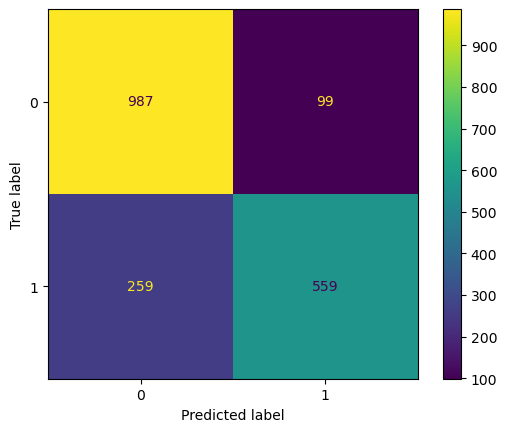

In [50]:
cm_cv = metrics.confusion_matrix(y_test, pred1)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix=cm_cv, display_labels=[0,1])
cm_display.plot()
plt.show()

In [51]:
test4 = tfidf_vec.transform(test2)

In [52]:
predtf = nb_classifier.predict(test4)
df_id = pd.DataFrame({'id':test['id']})
df_tf = pd.DataFrame(predtf,columns=['target'])  
df_tf = pd.concat([df_id, df_tf],axis=1)
df_tf.head()

,id,target
0,0,0
1,2,1
2,3,1
3,9,1
4,11,1


In [183]:
df_tf.to_csv('target_tfid.csv', index=False)

## BERTFinetuning

In [26]:
train_text, temp_text, train_labels, temp_labels = train_test_split(X, y, 
                                                                    random_state = 2021, 
                                                                    test_size = 0.3, 
                                                                    stratify = y)
  
val_text, test_text, val_labels, test_labels = train_test_split(temp_text, temp_labels, 
                                                                random_state = 2021, 
                                                                test_size = 0.5, 
                                                                stratify = temp_labels)

In [27]:
# import BERT-base pretrained model
bert = AutoModel.from_pretrained('bert-base-uncased')

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [28]:
#load model and tokenizer
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

(array([ 240.,  562.,  948., 1208., 1045.,  815.,  381.,  102.,   25.,
           3.]),
 array([ 0. ,  2.1,  4.2,  6.3,  8.4, 10.5, 12.6, 14.7, 16.8, 18.9, 21. ]),
 <BarContainer object of 10 artists>)

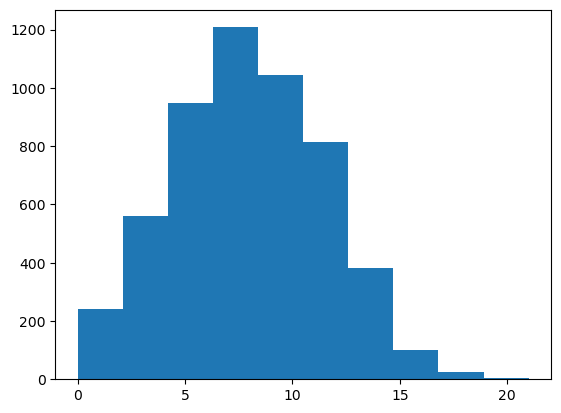

In [29]:
train_lens = [len(i.split()) for i in train_text]
plt.hist(train_lens)

In [30]:
pad_len = 11
# tokenize and encode sequences 
tokens_train = tokenizer.batch_encode_plus(
    train_text.tolist(),
    max_length = pad_len,
    padding = True,
    truncation = True
)
  
tokens_val = tokenizer.batch_encode_plus(
    val_text.tolist(),
    max_length = pad_len,
    padding = True,
    truncation = True
)
  
tokens_test = tokenizer.batch_encode_plus(
    test_text.tolist(),
    max_length = pad_len,
    padding = True,
    truncation = True
)
  
train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(train_labels.tolist())
  
val_seq = torch.tensor(tokens_val['input_ids'])
val_mask = torch.tensor(tokens_val['attention_mask'])
val_y = torch.tensor(val_labels.tolist())
  
test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])
test_y = torch.tensor(test_labels.tolist())

In [31]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

#define a batch size
batch_size = 64

# wrap tensors
train_data = TensorDataset(train_seq, train_mask, train_y)

# sampler for sampling the data during training
train_sampler = RandomSampler(train_data)

# dataLoader for train set
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# wrap tensors
val_data = TensorDataset(val_seq, val_mask, val_y)

# sampler for sampling the data during training
val_sampler = SequentialSampler(val_data)

# dataLoader for validation set
val_dataloader = DataLoader(val_data, sampler = val_sampler, batch_size=batch_size)

In [32]:
#freeze the pretrained layers
for param in bert.parameters():
    param.requires_grad = False
  
#defining new layers
class BERT_architecture(nn.Module):
  
    def __init__(self, bert):
        
      super(BERT_architecture, self).__init__()
  
      self.bert = bert 
        
      # dropout layer
      self.dropout = nn.Dropout(0.2)
        
      # relu activation function
      self.relu =  nn.ReLU()
  
      # dense layer 1
      self.fc1 = nn.Linear(768,512)
        
      # dense layer 2 (Output layer)
      self.fc2 = nn.Linear(512,2)
  
      #softmax activation function
      self.softmax = nn.LogSoftmax(dim=1)
  
    #define the forward pass
    def forward(self, sent_id, mask):
  
      #pass the inputs to the model  
      _, cls_hs = self.bert(sent_id, attention_mask=mask, return_dict=False)
        
      x = self.fc1(cls_hs)
  
      x = self.relu(x)
  
      x = self.dropout(x)
  
      # output layer
      x = self.fc2(x)
        
      # apply softmax activation
      x = self.softmax(x)
  
      return x

In [35]:
# pass the pre-trained BERT to our define architecture
model = BERT_architecture(bert)

# push the model to GPU
model = model.to(device)

In [36]:
# optimizer from hugging face transformers
from transformers import AdamW

# define the optimizer
optimizer = AdamW(model.parameters(),lr = 1e-5)  # learning rate

C:\Users\USER\anaconda3\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [37]:
from sklearn.utils.class_weight import compute_class_weight

#compute the class weights
class_weights = compute_class_weight(class_weight = "balanced",
                                        classes = np.unique(train_labels),
                                        y = train_labels 
                                     )
print("class weights are {} for {}".format(class_weights,np.unique(train_labels)))

class weights are [0.87676867 1.16353712] for [0 1]


In [38]:
#count of both the categories of training labels
pd.value_counts(train_labels)

target
0    3039
1    2290
Name: count, dtype: int64

In [39]:
#wrap class weights in tensor
weights= torch.tensor(class_weights,dtype=torch.float)

# push weights to GPU
weights = weights.to(device)

# define loss function
# add weights to handle the "imbalance" in the dataset
cross_entropy  = nn.NLLLoss(weight=weights) 

# number of training epochs
epochs = 10
     

In [40]:
# function to train the model
def train():
  
  model.train()

  total_loss, total_accuracy = 0, 0
  
  # empty list to save model predictions
  total_preds=[]
  
  # iterate over batches
  for step,batch in enumerate(train_dataloader):
    
    # progress update after every 50 batches.
    if step % 50 == 0 and not step == 0:
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(train_dataloader)))

    # push the batch to gpu
    batch = [r.to(device) for r in batch]
 
    sent_id, mask, labels = batch

    # clear previously calculated gradients 
    model.zero_grad()        

    # get model predictions for the current batch
    preds = model(sent_id, mask)

    # compute the loss between actual and predicted values
    loss = cross_entropy(preds, labels)

    # add on to the total loss
    total_loss = total_loss + loss.item()

    # backward pass to calculate the gradients
    loss.backward()

    # clip the the gradients to 1.0. It helps in preventing the exploding gradient problem
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

    # update parameters
    optimizer.step()

    # model predictions are stored on GPU. So, push it to CPU
    preds=preds.detach().cpu().numpy()

    # append the model predictions
    total_preds.append(preds)

  # compute the training loss of the epoch
  avg_loss = total_loss / len(train_dataloader)
  
  # predictions are in the form of (no. of batches, size of batch, no. of classes).
  # reshape the predictions in form of (number of samples, no. of classes)
  total_preds  = np.concatenate(total_preds, axis=0)

  #returns the loss and predictions
  return avg_loss, total_preds

In [41]:
# function for evaluating the model
def evaluate():
  
  print("\nEvaluating...")
  
  # deactivate dropout layers
  model.eval()

  total_loss, total_accuracy = 0, 0
  
  # empty list to save the model predictions
  total_preds = []

  # iterate over batches
  for step,batch in enumerate(val_dataloader):
    
    # Progress update every 50 batches.
    if step % 50 == 0 and not step == 0:
      
      # # Calculate elapsed time in minutes.
      # elapsed = format_time(time.time() - t0)
            
      # Report progress.
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(val_dataloader)))

    # push the batch to gpu
    batch = [t.to(device) for t in batch]

    sent_id, mask, labels = batch

    # deactivate autograd
    with torch.no_grad():
      
      # model predictions
      preds = model(sent_id, mask)

      # compute the validation loss between actual and predicted values
      loss = cross_entropy(preds,labels)

      total_loss = total_loss + loss.item()

      preds = preds.detach().cpu().numpy()

      total_preds.append(preds)

  # compute the validation loss of the epoch
  avg_loss = total_loss / len(val_dataloader) 

  # reshape the predictions in form of (number of samples, no. of classes)
  total_preds  = np.concatenate(total_preds, axis=0)

  return avg_loss, total_preds

In [42]:
# set initial loss to infinite
best_valid_loss = float('inf')

# empty lists to store training and validation loss of each epoch
train_losses=[]
valid_losses=[]

#for each epoch
for epoch in range(epochs):
     
    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))
    
    #train model
    train_loss, _ = train()
    
    #evaluate model
    valid_loss, _ = evaluate()
    
    #save the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'saved_weights.pt')
    
    # append training and validation loss
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    
    print('\nTraining Loss: {}'.format(train_loss))
    print('Validation Loss: {}'.format(valid_loss))


 Epoch 1 / 10
  Batch    50  of     84.

Evaluating...

Training Loss: 0.6907715974819093
Validation Loss: 0.6739249262544844

 Epoch 2 / 10
  Batch    50  of     84.

Evaluating...

Training Loss: 0.6793463187558311
Validation Loss: 0.6657498445775774

 Epoch 3 / 10
  Batch    50  of     84.

Evaluating...

Training Loss: 0.6722390971013478
Validation Loss: 0.6560892926322089

 Epoch 4 / 10
  Batch    50  of     84.

Evaluating...

Training Loss: 0.6650897853431248
Validation Loss: 0.6468167437447442

 Epoch 5 / 10
  Batch    50  of     84.

Evaluating...

Training Loss: 0.6601143983148393
Validation Loss: 0.6408714883857303

 Epoch 6 / 10
  Batch    50  of     84.

Evaluating...

Training Loss: 0.653695862208094
Validation Loss: 0.6335406833224826

 Epoch 7 / 10
  Batch    50  of     84.

Evaluating...

Training Loss: 0.6483381504104251
Validation Loss: 0.6268997755315568

 Epoch 8 / 10
  Batch    50  of     84.

Evaluating...

Training Loss: 0.6465347309907278
Validation Loss: 0.62

In [43]:
#load weights of best model
path = 'saved_weights.pt'
model.load_state_dict(torch.load(path))

<All keys matched successfully>

In [44]:
# get predictions for test data
with torch.no_grad():
  preds = model(test_seq.to(device), test_mask.to(device))
  preds = preds.detach().cpu().numpy()

In [45]:
pred = np.argmax(preds, axis = 1)
print(metrics.classification_report(test_y, pred))

              precision    recall  f1-score   support

           0       0.75      0.61      0.67       652
           1       0.58      0.72      0.65       490

    accuracy                           0.66      1142
   macro avg       0.66      0.67      0.66      1142
weighted avg       0.68      0.66      0.66      1142



In [47]:
tokens_test2 = tokenizer.batch_encode_plus(
    test2.tolist(),
    max_length = pad_len,
    padding = True,
    truncation = True
)


test_seq = torch.tensor(tokens_test2['input_ids'])
test_mask = torch.tensor(tokens_test2['attention_mask'])


In [48]:
with torch.no_grad():
  preds = model(test_seq.to(device), test_mask.to(device))
  preds = preds.detach().cpu().numpy()

In [49]:
yhat = np.argmax(preds, axis = 1)
df_id = pd.DataFrame({'id':test['id']})
df_mn = pd.DataFrame(yhat,columns=['target'])  
df_mn = pd.concat([df_id, df_mn],axis=1)
df_mn.head()

,id,target
0,0,1
1,2,1
2,3,0
3,9,1
4,11,1


In [50]:
df_mn.to_csv('target_berth.csv', index=False)

## Using DEEP LEARNING

In [25]:
X = bow_train.toarray()
X.shape

(5709, 10002)

In [26]:
X2 = bow_test.toarray()
X2.shape

(1904, 10002)

In [27]:
type(X)

numpy.ndarray

In [336]:
model = None

In [337]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, BatchNormalization

model = Sequential([
    Dense(6, kernel_initializer='random_normal', activation='relu', input_shape=(10002,)),
    #BatchNormalization(),
    
    Dropout(0.2),
    
    #Dense(256, kernel_initializer='random_normal', activation='relu'),
    #BatchNormalization(),
    
    #Dropout(0.2),
    
    #Dense(512, kernel_initializer='random_normal', activation='relu'),
    #BatchNormalization(),
    
    #Dropout(0.2),
    
    #Dense(256, kernel_initializer='random_normal', activation='relu'),
    #BatchNormalization(),
    
    #Dropout(0.2),
    
    Dense(1, activation='sigmoid'),
])


# Compile the model with binary cross-entropy loss and Adam optimizer
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [338]:
model.summary()

Model: "sequential_63"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_197 (Dense)           (None, 6)                 60018     
                                                                 
 dropout_76 (Dropout)        (None, 6)                 0         
                                                                 
 dense_198 (Dense)           (None, 1)                 7         
                                                                 
Total params: 60,025
Trainable params: 60,025
Non-trainable params: 0
_________________________________________________________________


In [339]:
# Fit the model to the training data
history = model.fit(X, y_train, epochs=10, batch_size=64, validation_split=0.3)

# Evaluate the model on the test data
loss, accuracy = model.evaluate(X2, y_test)
print(f'Test Accuracy: {accuracy}')

Epoch 1/10
63/63 [==============================] - 1s 11ms/step - loss: 0.6807 - accuracy: 0.5906 - val_loss: 0.6606 - val_accuracy: 0.6643
Epoch 2/10
63/63 [==============================] - 1s 9ms/step - loss: 0.6298 - accuracy: 0.6977 - val_loss: 0.6203 - val_accuracy: 0.7157
Epoch 3/10
63/63 [==============================] - 1s 9ms/step - loss: 0.5621 - accuracy: 0.7725 - val_loss: 0.5742 - val_accuracy: 0.7572
Epoch 4/10
63/63 [==============================] - 1s 8ms/step - loss: 0.4909 - accuracy: 0.8191 - val_loss: 0.5379 - val_accuracy: 0.7723
Epoch 5/10
63/63 [==============================] - 1s 8ms/step - loss: 0.4288 - accuracy: 0.8481 - val_loss: 0.5127 - val_accuracy: 0.7840
Epoch 6/10
63/63 [==============================] - 0s 8ms/step - loss: 0.3758 - accuracy: 0.8766 - val_loss: 0.4954 - val_accuracy: 0.7922
Epoch 7/10
63/63 [==============================] - 0s 8ms/step - loss: 0.3366 - accuracy: 0.8949 - val_loss: 0.4861 - val_accuracy: 0.7928
Epoch 8/10
63/63 [=

In [340]:
# Make predictions
yhat = model.predict(X2)
yhat_class = [1 if x>=0.5 else 0 for x in yhat]
print('Predicted values:', yhat[:10])
print(yhat_class)

60/60 [==============================] - 0s 3ms/step
Predicted values: [[0.51684767]
 [0.32409495]
 [0.06326396]
 [0.02817363]
 [0.1759242 ]
 [0.12638249]
 [0.9734285 ]
 [0.20114607]
 [0.28026792]
 [0.04124923]]
[1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0

In [341]:
tf.math.confusion_matrix(
    labels=y_test,
    predictions=yhat_class,
    num_classes=2,)

<tf.Tensor: shape=(2, 2), dtype=int32, numpy=
array([[977, 109],
       [266, 552]])>

In [342]:
Accuracy_dnn = metrics.accuracy_score(y_test, yhat_class)
Precision_dnn = metrics.precision_score(y_test, yhat_class)
Sensitivity_dnn = metrics.recall_score(y_test, yhat_class)
Specificity_dnn = metrics.recall_score(y_test, yhat_class, pos_label=0)
F1_score_dnn = metrics.f1_score(y_test, yhat_class)
Jaccard_dnn = metrics.jaccard_score(y_test, yhat_class)
roc_auc_dnn = metrics.roc_auc_score(y_test, yhat_class)
print("KNN's F1 Score: ",F1_score_dnn)
print("KNN's Specificity: ", Specificity_dnn)
print("KNN's Sensitivity: ", Sensitivity_dnn)
print("KNN's Precision: ", Precision_dnn)
print("KNN's Accuracy: ", Accuracy_dnn)
print("KNN's Jaccard Score: ", Jaccard_dnn)
print('AUC:', roc_auc_dnn)

KNN's F1 Score:  0.746450304259635
KNN's Specificity:  0.8996316758747698
KNN's Sensitivity:  0.6748166259168704
KNN's Precision:  0.8350983358547656
KNN's Accuracy:  0.803046218487395
KNN's Jaccard Score:  0.5954692556634305
AUC: 0.78722415089582


In [343]:
test_main = test3.toarray()
type(test_main)

numpy.ndarray

In [344]:
preddp = model.predict(test_main)
preddp = [1 if x>=0.5 else 0 for x in preddp]
df_id = pd.DataFrame({'id':test['id']})
df_tf = pd.DataFrame(preddp,columns=['target'])  
df_tf = pd.concat([df_id, df_tf],axis=1)
df_tf.head()

102/102 [==============================] - 0s 3ms/step


,id,target
0,0,1
1,2,1
2,3,1
3,9,1
4,11,1


In [345]:
df_tf['target'].value_counts()

target
0    2112
1    1151
Name: count, dtype: int64

In [346]:
df_tf.to_csv('target_deep4.csv', index=False)